In [8]:
# Cell 1: Imports
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torch.optim as optim
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [9]:
# Cell 2: Dataset Class
class CoronaryDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Get all jpg files and their corresponding labels from txt files
        self.samples = []
        for fname in os.listdir(image_dir):
            if fname.endswith(".jpg"):
                img_path = os.path.join(image_dir, fname)
                txt_path = os.path.join(image_dir, fname.replace(".jpg", ".txt"))
                # Check if the txt file exists
                if os.path.exists(txt_path):
                    try:
                        with open(txt_path, 'r') as f:
                            label = int(f.read().strip())
                        self.samples.append((img_path, label))
                    except (ValueError, FileNotFoundError):
                        print(f"Skipping {fname}: Issue with label file")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
# Cell 3: Dataset Setup
# Set the correct dataset path
PROCESSED_DIR = "arterydir"

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = CoronaryDataset(PROCESSED_DIR, transform=transform)
print(f"Total samples found: {len(dataset)}")

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

Total samples found: 4238


In [11]:
# Cell 4: Model Setup
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)  # 3 classes: RCA, LAD, LCX
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


c:\ProgramData\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Cell 5: Training and Validation Functions
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return train_loss / len(loader), 100 * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return val_loss / len(loader), 100 * correct / total, all_preds, all_labels

In [14]:
# Cell 6: Training Loop with History Recording
num_epochs = 10
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"[VGG16] Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

[VGG16] Epoch 1, Train Loss: 1.0354, Train Acc: 70.97%, Val Loss: 0.4520, Val Acc: 81.25%
[VGG16] Epoch 2, Train Loss: 0.4422, Train Acc: 82.36%, Val Loss: 0.4155, Val Acc: 83.14%
[VGG16] Epoch 3, Train Loss: 0.4189, Train Acc: 84.57%, Val Loss: 0.3987, Val Acc: 84.67%
[VGG16] Epoch 4, Train Loss: 0.4175, Train Acc: 84.25%, Val Loss: 0.3786, Val Acc: 83.37%
[VGG16] Epoch 5, Train Loss: 0.3706, Train Acc: 86.25%, Val Loss: 0.3583, Val Acc: 85.50%
[VGG16] Epoch 6, Train Loss: 0.3477, Train Acc: 87.14%, Val Loss: 0.3154, Val Acc: 87.15%
[VGG16] Epoch 7, Train Loss: 0.3191, Train Acc: 87.67%, Val Loss: 0.3612, Val Acc: 86.91%
[VGG16] Epoch 8, Train Loss: 0.2908, Train Acc: 88.58%, Val Loss: 0.3262, Val Acc: 87.97%
[VGG16] Epoch 9, Train Loss: 0.2801, Train Acc: 88.91%, Val Loss: 0.2941, Val Acc: 87.97%
[VGG16] Epoch 10, Train Loss: 0.2597, Train Acc: 90.44%, Val Loss: 0.2959, Val Acc: 88.80%


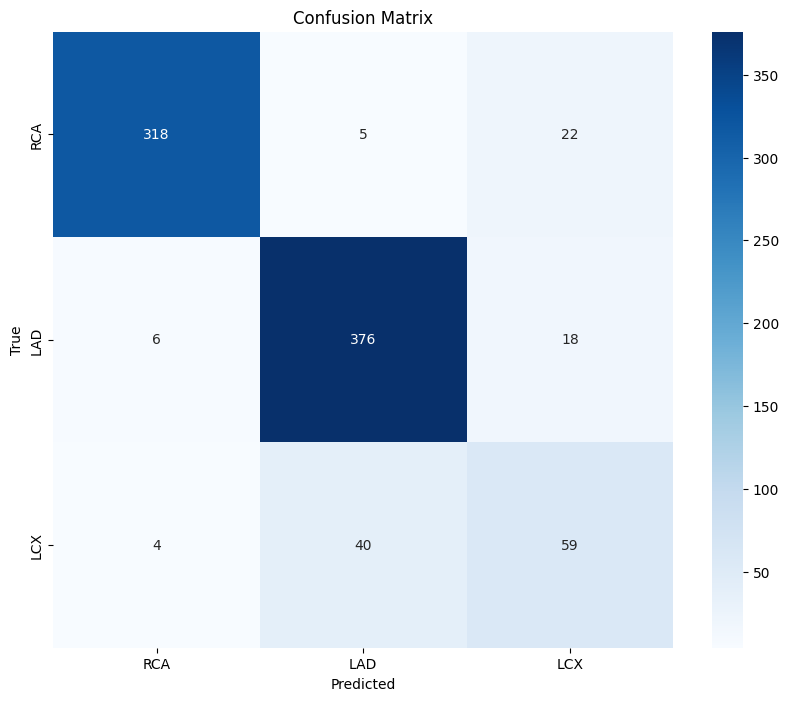

Classification Report:
              precision    recall  f1-score   support

         RCA       0.97      0.92      0.95       345
         LAD       0.89      0.94      0.92       400
         LCX       0.60      0.57      0.58       103

    accuracy                           0.89       848
   macro avg       0.82      0.81      0.82       848
weighted avg       0.89      0.89      0.89       848



In [15]:
# Cell 7: Final Evaluation and Confusion Matrix
# Final evaluation
_, _, all_preds, all_labels = validate(model, val_loader, criterion, device)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ["RCA", "LAD", "LCX"]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

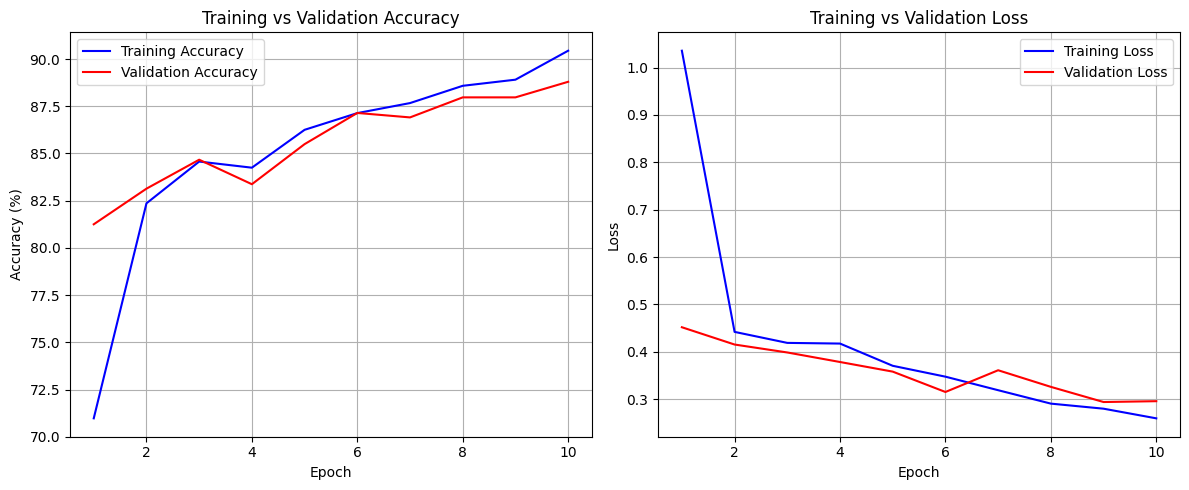

In [16]:
# Cell 8: Plotting Accuracy Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accs, 'b-', label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plotting Loss Graph
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Cell 9: Save the model
model_save_path = "vgg16_artery_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to vgg16_artery_model.pth


In [18]:
# Cell 10: Inference Function
def predict_artery(img_path, model, transform):
    # Load and preprocess the image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error: Could not load image from {img_path}")
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)
    image_tensor = transform(image_pil).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    
    label_map = {0: "RCA", 1: "LAD", 2: "LCX"}
    predicted_label = label_map[predicted.item()]
    
    return predicted_label

In [19]:
# Cell 11: Test the model on a sample image
test_img_path = os.path.join(PROCESSED_DIR, "1_161.jpg")  # Update this to a specific image path that exists
if os.path.exists(test_img_path):
    prediction = predict_artery(test_img_path, model, transform)
    print(f"Predicted Artery: {prediction}")
else:
    print(f"Test image not found at {test_img_path}")
    # Find first available image for testing
    sample_images = [f for f in os.listdir(PROCESSED_DIR) if f.endswith('.jpg')]
    if sample_images:
        test_img_path = os.path.join(PROCESSED_DIR, sample_images[0])
        print(f"Using alternative image: {test_img_path}")
        prediction = predict_artery(test_img_path, model, transform)
        print(f"Predicted Artery: {prediction}")
    else:
        print("No jpg images found in the dataset directory.")

Predicted Artery: RCA
